In this notebook:
1. Get county demographic data: 
    + county_demographics_df.csv
    + jail_county_demographics_df.csv (jail_county_df.csv + county_demographics_df.csv)
2. county clustering
    + simple k-means

In [1]:
library('tidyverse')
library('repr')
library('factoextra')

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1     v purrr   0.3.2
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'factoextra' was built under R version 3.6.3"Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


In [54]:
# load datasets

# --------------
# from jessica:
# jail_county_df, without the index column X
jail_county_df <- read.csv('jail_county_df.csv', stringsAsFactors = FALSE)[ , 2:10]

# prison_county_df, without the index column X
prison_county_df <- read.csv('prison_county_df.csv', stringsAsFactors = FALSE)[ , 2:7]
#  capitalize county name:
prison_county_df$county <- str_to_title(prison_county_df$county)

# nytimes
us_counties <- read.csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', 
                        colClasses = c('Date', 'factor', 'factor', 'factor', NA, NA))

# vera inst
#jail_population <- read.csv('https://raw.githubusercontent.com/vera-institute/jail-population-data/master/jail_population.csv')


# merge with demographics datasets

# --------------
# county demographics: 
#   https://github.com/ringhilterra/enriched-covid19-data
county_demographics_df <- read.csv('https://raw.githubusercontent.com/ringhilterra/enriched-covid19-data/master/us_county_demographics.csv', 
                                   colClasses = c('factor', 'factor', rep(NA, 19) ),
                                   stringsAsFactors = FALSE)
# combine state and county fips into one fips column
county_demographics_df$state_fips <- str_pad(county_demographics_df$state_fips, 2, pad="0")
county_demographics_df$county_fips <- str_pad(county_demographics_df$county_fips, 3, pad="0")
county_demographics_df$fips <- paste(county_demographics_df$state_fips, county_demographics_df$county_fips, sep="")

#  tidy up column names: convert to lower case
names(county_demographics_df) <- str_to_lower(names(county_demographics_df))
#  remove word "county" from county column
county_demographics_df$county <- sub(county_demographics_df$county, pattern = " [[:alpha:]]*$", replacement = "")

# -------------- 
# clean up county_demographic_df
#  note: county populations from this dataset is similar but not the same as nytimes/vera inst.
#   We'll use just the other columns (race/ethnicity, age, gender, etc.)
county_demographics_df <- county_demographics_df[ , c(4, 3, 22, 5:21)]

            
# compute age group percentages instead of count, and
#  add lowrisk_agegroup_perc and highrisk_agegroup_perc columns:
county_demographics_df <- county_demographics_df %>%
    mutate(age_oto4_perc = age_oto4/tot_pop,
          age_5to14_perc = age_5to14/tot_pop,
          age_15to24_perc = age_15to24/tot_pop,
          age_25to34_perc = age_25to34/tot_pop,
          age_35to44_perc = age_35to44/tot_pop,
          age_45to54_perc = age_45to54/tot_pop,
          age_55to64_perc = age_55to64/tot_pop,
          age_65to74_perc = age_65to74/tot_pop,
          age_75to84_perc = age_75to84/tot_pop,
          age_84plus_perc = age_84plus/tot_pop,
          'lowrisk_agegroup_perc' = rowSums(. [11:17])/tot_pop ,
          'highrisk_agegroup_perc' = rowSums(. [18:20])/tot_pop) 

# remove age group count:
#  (note: resident_population (from vera inst) and tot_pop columns are close but not equal)
county_demographics_df <- county_demographics_df[ , c(1:10, 21:31)]

# ---------------
# county land area and population data
# from https://github.com/ykzeng/covid-19/tree/master/data
landarea <- read.csv('https://raw.githubusercontent.com/ykzeng/covid-19/master/data/census-population-landarea.csv',
                    colClasses = c('factor', rep(NA, 6)) )
landarea$fips <- str_pad(landarea$fips, 5, pad = "0")

# fip-county key
fips_key <- read.csv('https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_and_county_fips_master.csv',
                    colClasses = c('factor', rep(NA, 2)))
fips_key$fips <- str_pad(fips_key$fips, 5, pad = "0")


# --------------
# join landarea and fips_county to get landarea information for each county
#landarea_county <- left_join( landarea, fips_key, by="fips")


#take only columns fips, county, state, LND110210, 
#landarea_county <- landarea_county[, c(1, 8, 9, 6) ]
# rename column LND110210 to land_area
#names(landarea_county)[4] <- 'land_area'

landarea <- landarea[ , c(1, 6)]
names(landarea)[2] <- 'land_area'
head(landarea)

# --------------
# join demographics + landarea datasets
county_demographics_df <- left_join(county_demographics_df, landarea, by=c("fips") )
# add a population density column
county_demographics_df <- county_demographics_df %>% 
    mutate(population_density = tot_pop / land_area )

# --------------
# join jessica's jail dataset + (demographics + landarea) datasets
#jail_county_demographics_df <- full_join( jail_county_df, county_demographics_df, by = c('county', 'state')) 

# add infection rate column
#jail_county_demographics_df <- jail_county_demographics_df %>%
#    mutate( pop_infection_rate = cases/resident_population )

fips,land_area
00000,3531905.43
01000,50645.33
01001,594.44
01003,1589.78
01005,884.88
01007,622.58


In [55]:
# intermediate check
head(county_demographics_df)
names(county_demographics_df)

county,state,fips,tot_pop,male_perc,female_perc,white_pop_perc,black_pop_perc,asian_pop_perc,hisp_pop_perc,...,age_25to34_perc,age_35to44_perc,age_45to54_perc,age_55to64_perc,age_65to74_perc,age_75to84_perc,age_84plus_perc,lowrisk_agegroup_perc,land_area,population_density
Autauga,Alabama,01001,55601,0.4855129,0.5144871,0.7837989,0.20616536,0.017301847,0.02965774,...,0.1288826,0.1302854,0.1398716,0.1288466,0.08812791,0.05183360,0.01566519,0.8443733,594.44,93.53509
Baldwin,Alabama,01003,218022,0.4846162,0.5153838,0.8895983,0.09688472,0.015613103,0.04646779,...,0.1125024,0.1194054,0.1316519,0.1440634,0.12263900,0.06205337,0.01974113,0.7955665,1589.78,137.13973
Barbour,Alabama,01005,24881,0.5278325,0.4721675,0.5003416,0.49290623,0.006068888,0.04276355,...,0.1393031,0.1198103,0.1296974,0.1290543,0.11563040,0.05960371,0.01897030,0.8057956,884.88,28.11794
Bibb,Alabama,01007,22400,0.5321875,0.4678125,0.7781250,0.21901786,0.003794643,0.02625000,...,0.1485268,0.1317857,0.1419196,0.1293304,0.09705357,0.05147321,0.01620536,0.8352679,622.58,35.97931
Blount,Alabama,01009,57840,0.4927386,0.5072614,0.9718361,0.02162863,0.005411480,0.09571231,...,0.1198824,0.1221819,0.1351660,0.1319156,0.10793568,0.05658714,0.01784232,0.8176349,644.78,89.70502
Bullock,Alabama,01011,10138,0.5451766,0.4548234,0.2735254,0.71404616,0.004044190,0.07960150,...,0.1505228,0.1291182,0.1240876,0.1410535,0.09350957,0.05217992,0.01814954,0.8361610,622.81,16.27784


[1] "county"                "state"                 "fips"                 
 [4] "tot_pop"               "male_perc"             "female_perc"          
 [7] "white_pop_perc"        "black_pop_perc"        "asian_pop_perc"       
[10] "hisp_pop_perc"         "age_oto4_perc"         "age_5to14_perc"       
[13] "age_15to24_perc"       "age_25to34_perc"       "age_35to44_perc"      
[16] "age_45to54_perc"       "age_55to64_perc"       "age_65to74_perc"      
[19] "age_75to84_perc"       "age_84plus_perc"       "lowrisk_agegroup_perc"
[22] "land_area"             "population_density"

In [56]:
# intermediate check
landarea <- read.csv('https://raw.githubusercontent.com/ykzeng/covid-19/master/data/census-population-landarea.csv',
                    colClasses = c('factor', rep(NA, 6)) )
landarea$fips <- str_pad(landarea$fips, 5, pad = "0")
head(landarea)

fips,PST045212,PST040210,PST120212,POP010210,LND110210,POP060210
00000,313914040,308747508,1.7,308745538,3531905.43,87.4
01000,4822023,4779745,0.9,4779736,50645.33,94.4
01001,55514,54571,1.7,54571,594.44,91.8
01003,190790,182265,4.7,182265,1589.78,114.6
01005,27201,27457,-0.9,27457,884.88,31.0
01007,22597,22919,-1.4,22915,622.58,36.8


In [58]:
county_demographics_df

county,state,fips,tot_pop,male_perc,female_perc,white_pop_perc,black_pop_perc,asian_pop_perc,hisp_pop_perc,...,age_25to34_perc,age_35to44_perc,age_45to54_perc,age_55to64_perc,age_65to74_perc,age_75to84_perc,age_84plus_perc,lowrisk_agegroup_perc,land_area,population_density
Autauga,Alabama,01001,55601,0.4855129,0.5144871,0.7837989,0.20616536,0.017301847,0.02965774,...,0.1288826,0.1302854,0.1398716,0.1288466,0.08812791,0.05183360,0.01566519,0.8443733,594.44,93.53509
Baldwin,Alabama,01003,218022,0.4846162,0.5153838,0.8895983,0.09688472,0.015613103,0.04646779,...,0.1125024,0.1194054,0.1316519,0.1440634,0.12263900,0.06205337,0.01974113,0.7955665,1589.78,137.13973
Barbour,Alabama,01005,24881,0.5278325,0.4721675,0.5003416,0.49290623,0.006068888,0.04276355,...,0.1393031,0.1198103,0.1296974,0.1290543,0.11563040,0.05960371,0.01897030,0.8057956,884.88,28.11794
Bibb,Alabama,01007,22400,0.5321875,0.4678125,0.7781250,0.21901786,0.003794643,0.02625000,...,0.1485268,0.1317857,0.1419196,0.1293304,0.09705357,0.05147321,0.01620536,0.8352679,622.58,35.97931
Blount,Alabama,01009,57840,0.4927386,0.5072614,0.9718361,0.02162863,0.005411480,0.09571231,...,0.1198824,0.1221819,0.1351660,0.1319156,0.10793568,0.05658714,0.01784232,0.8176349,644.78,89.70502
Bullock,Alabama,01011,10138,0.5451766,0.4548234,0.2735254,0.71404616,0.004044190,0.07960150,...,0.1505228,0.1291182,0.1240876,0.1410535,0.09350957,0.05217992,0.01814954,0.8361610,622.81,16.27784
Butler,Alabama,01013,19680,0.4657012,0.5342988,0.5325711,0.45553862,0.014939024,0.01509146,...,0.1158028,0.1214431,0.1175305,0.1423272,0.11178862,0.06148374,0.02972561,0.7970020,776.83,25.33373
Calhoun,Alabama,01015,114277,0.4805341,0.5194659,0.7708638,0.22228445,0.014106076,0.03910673,...,0.1317763,0.1194116,0.1251608,0.1396431,0.10567306,0.05302904,0.01847266,0.8228252,605.87,188.61637
Chambers,Alabama,01017,33615,0.4787446,0.5212554,0.5822698,0.40788339,0.014755318,0.02561357,...,0.1258664,0.1123011,0.1311617,0.1472557,0.11423472,0.05869404,0.02228172,0.8047895,596.53,56.35090
Cherokee,Alabama,01019,26032,0.4953903,0.5046097,0.9461048,0.04963122,0.005262754,0.01621082,...,0.1057929,0.1063691,0.1379072,0.1574985,0.13617855,0.07294868,0.02059004,0.7702827,553.70,47.01463


In [57]:
head(county_demographics_df, 3)
write.csv(county_demographics_df, 'county_demographics_df.csv', row.names = FALSE)

county,state,fips,tot_pop,male_perc,female_perc,white_pop_perc,black_pop_perc,asian_pop_perc,hisp_pop_perc,...,age_25to34_perc,age_35to44_perc,age_45to54_perc,age_55to64_perc,age_65to74_perc,age_75to84_perc,age_84plus_perc,lowrisk_agegroup_perc,land_area,population_density
Autauga,Alabama,01001,55601,0.4855129,0.5144871,0.7837989,0.20616536,0.017301847,0.02965774,...,0.1288826,0.1302854,0.1398716,0.1288466,0.08812791,0.05183360,0.01566519,0.8443733,594.44,93.53509
Baldwin,Alabama,01003,218022,0.4846162,0.5153838,0.8895983,0.09688472,0.015613103,0.04646779,...,0.1125024,0.1194054,0.1316519,0.1440634,0.12263900,0.06205337,0.01974113,0.7955665,1589.78,137.13973
Barbour,Alabama,01005,24881,0.5278325,0.4721675,0.5003416,0.49290623,0.006068888,0.04276355,...,0.1393031,0.1198103,0.1296974,0.1290543,0.11563040,0.05960371,0.01897030,0.8057956,884.88,28.11794


### Filter by state, date

In [165]:
# filter jail_county_demographics_df 

#  consider only some states
selected_states <- 'California|Texas|Ohio|Oregon'
jail_county_demographics_filtered_df <- jail_county_demographics_df %>%
    filter( #grepl( selected_states, state) ,   # use all states
          jail_incarceration_rate_per_100k < 2000 ) # remove outlier counties



#  keep most recent data
jail_county_demographics_filtered_df$date <- as.Date(jail_county_demographics_filtered_df$date)

jail_county_demographics_filtered_df <- jail_county_demographics_filtered_df %>%
    group_by(county) %>% 
    filter(date == max(date))

Warning message:
"Removed 8 rows containing missing values (geom_point)."

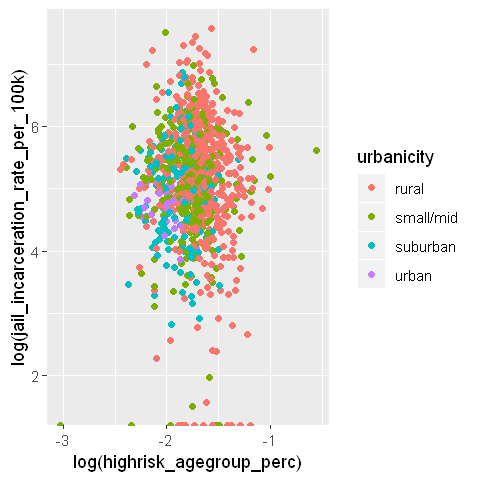

In [46]:
# try some plots
options(repr.plot.width=4, repr.plot.height=4)
ggplot(jail_county_demographics_filtered_df, 
       aes( x = log(highrisk_agegroup_perc), y = log(jail_incarceration_rate_per_100k), color = urbanicity) ) + 
            geom_point()

## k-means clustering + project to 2 principal components to visualize

In [167]:
# column names
#jail_county_demographics_columns <- data.frame( colindex = 1:31, colname = names(jail_county_demographics_df))
jail_county_demographics_columns

#county_demographics_columns <- data.frame( colindex = 1:23, colname = names(county_demographics_df))
#county_demographics_columns

colindex,colname
1,date
2,county
3,state
4,jail_population
5,resident_population
6,cases
7,deaths
8,jail_incarceration_rate_per_100k
9,urbanicity
10,tot_pop


cluster,count,ave_incarceration_rate,ave_jail_pop,ave_res_pop,ave_highrisk_agegroup_perc
1,788,232.42284,161.4657,94271.12,0.1829725
2,15,95.06667,3024.5333,2828677.53,0.1447733
3,168,280.87440,383.6488,230430.54,0.1671051


cluster,urbanicity,count,ave_incarceration_rate,ave_res_pop,ave_highrisk_agegroup_perc
1,rural,432,259.1706,31973.31,0.1935420
1,small/mid,242,205.3281,153191.85,0.1758847
1,suburban,109,191.7917,164340.42,0.1599914
1,urban,5,118.5600,1097528.40,0.1138086
2,suburban,5,73.9600,1362795.60,0.1589736
2,urban,10,105.6200,3561618.50,0.1376732
3,rural,68,339.0382,31351.25,0.1847879
3,small/mid,60,292.9233,168234.65,0.1655664
3,suburban,27,185.2815,355611.15,0.1383516
3,urban,13,119.5615,1298835.85,0.1414309


Importance of components:
                         PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.851 2.0795 1.56107 1.45509 1.31873 1.20157 1.16285
Proportion of Variance 0.301 0.1602 0.09026 0.07842 0.06441 0.05347 0.05008
Cumulative Proportion  0.301 0.4612 0.55140 0.62982 0.69423 0.74770 0.79779
                          PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.0495 0.95751 0.85663 0.73750 0.71328 0.60950 0.56516
Proportion of Variance 0.0408 0.03396 0.02718 0.02014 0.01884 0.01376 0.01183
Cumulative Proportion  0.8386 0.87254 0.89972 0.91986 0.93871 0.95247 0.96430
                          PC15    PC16    PC17   PC18   PC19    PC20    PC21
Standard deviation     0.55914 0.48379 0.40542 0.2597 0.2548 0.21312 0.19808
Proportion of Variance 0.01158 0.00867 0.00609 0.0025 0.0024 0.00168 0.00145
Cumulative Proportion  0.97588 0.98454 0.99063 0.9931 0.9955 0.99722 0.99867
                          PC22     PC23      PC24 

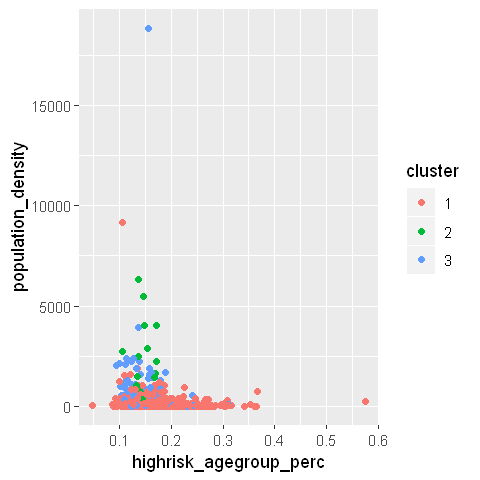

Saving 6.67 x 6.67 in image


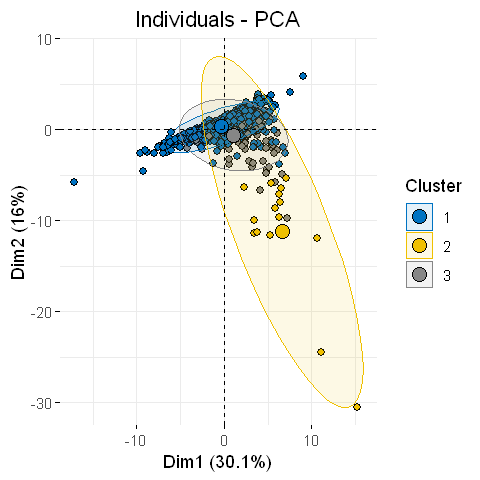

In [174]:
# k means
# k = 3

selected_column_indices <- c(4:8,11:16)
num_clusters <- 3 #try some number

jail_county_demographics_filtered_df_dropna <- drop_na(jail_county_demographics_filtered_df)

#opt_k <- fviz_nbclust(jail_county_demographics_filtered_df_dropna[ , selected_column_indices], kmeans, method = "gap_stat")

set.seed(42)
km <- kmeans(scale(jail_county_demographics_filtered_df_dropna[ , selected_column_indices]), num_clusters )
jail_county_demographics_filtered_df_dropna$cluster <- as.factor(km$cluster)
#write.csv(jail_county_demographics_filtered_df_dropna, 'jail_county_demographics_clustered_4means.csv', row.names=FALSE)


# get a sense of the clusters
options(repr.plot.width=4)
ggplot(jail_county_demographics_filtered_df_dropna, 
       aes( x = highrisk_agegroup_perc, y = population_density, color = cluster) ) + 
            geom_point()

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_jail_pop = mean(jail_population),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster, urbanicity ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

# pca to see clusters
#pca
data <- jail_county_demographics_filtered_df_dropna
selected_column_indices <- c(4:8,10:31)

pca <- prcomp(data[ , selected_column_indices], center = TRUE, scale = TRUE)
summary(pca)

# principal components + clusters
plot <- fviz_pca_ind(pca, geom.ind = "point", pointshape = 21, 
             pointsize = 2, 
             fill.ind = data$cluster, 
             col.ind = "black", 
             palette = "jco", 
             addEllipses = TRUE,
             label = "var",
             col.var = "black",
             repel = TRUE,
             legend.title = "Cluster") +
  theme(plot.title = element_text(hjust = 0.5))
plot 
#ggsave('3clusterpca.png', plot)

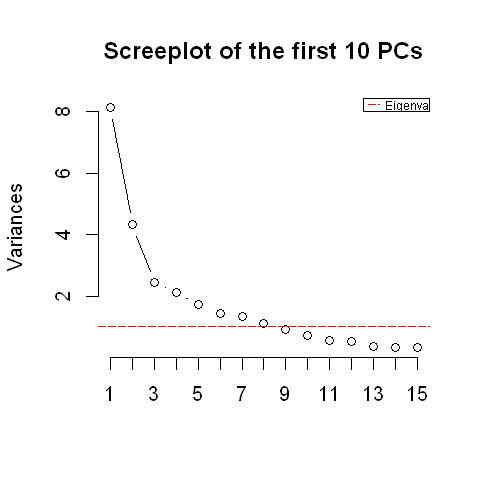

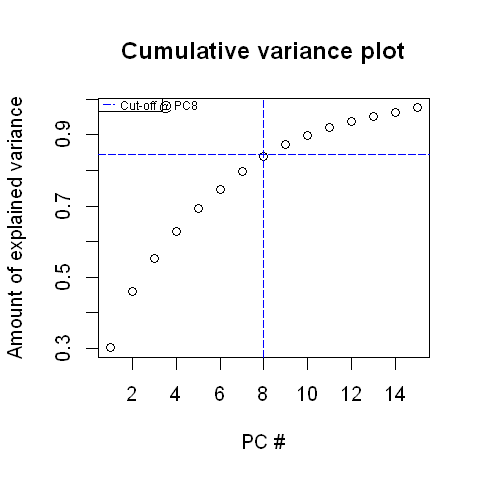

In [169]:
# more on pca

# initial plots
#plot(pca$x[,1],pca$x[,2], xlab="PC1 (29.9%)", ylab = "PC2 (17.8%)", main = "PC1 / PC2 - plot")

#scree plots
screeplot(pca, type = "l", npcs = 15, main = "Screeplot of the first 10 PCs")
abline(h = 1, col="red", lty=5)
legend("topright", legend=c("Eigenvalue = 1"),
       col=c("red"), lty=5, cex=0.6)
cumpro <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
plot(cumpro[0:15], xlab = "PC #", ylab = "Amount of explained variance", main = "Cumulative variance plot")
abline(v = 8, col="blue", lty=5)
abline(h = 0.845, col="blue", lty=5)
legend("topleft", legend=c("Cut-off @ PC8"),
       col=c("blue"), lty=5, cex=0.6)

cluster,count,ave_incarceration_rate,ave_jail_pop,ave_res_pop,ave_highrisk_agegroup_perc
1,140,181.59143,82.97857,46244.93,0.2548209
2,266,212.91842,410.70301,263109.65,0.1341650
3,553,268.90235,145.97288,78645.64,0.1831813
4,12,83.33333,2955.75000,2956303.75,0.1471266


cluster,urbanicity,count,ave_incarceration_rate,ave_res_pop,ave_highrisk_agegroup_perc
1,rural,109,175.86514,29229.49,0.2510332
1,small/mid,25,213.82000,103033.60,0.2774696
1,suburban,6,151.33333,118739.33,0.2292599
2,rural,93,246.89355,31421.99,0.1396095
2,small/mid,99,232.82020,232453.48,0.1337359
2,suburban,57,149.48947,356095.05,0.1281207
2,urban,17,123.82941,1397330.00,0.1271446
3,rural,298,311.69765,33007.04,0.1873470
3,small/mid,178,218.37135,121223.43,0.1815814
3,suburban,75,223.31733,132565.63,0.1703980


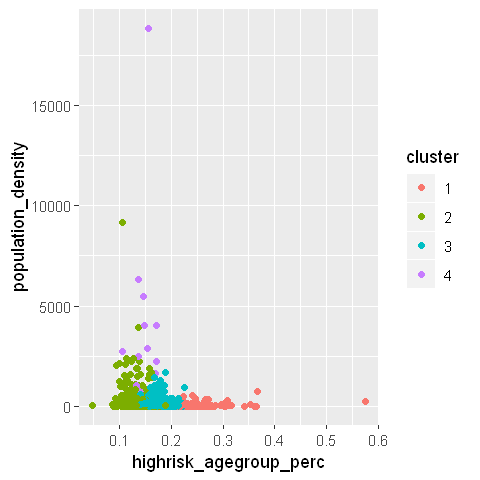

Saving 6.67 x 6.67 in image


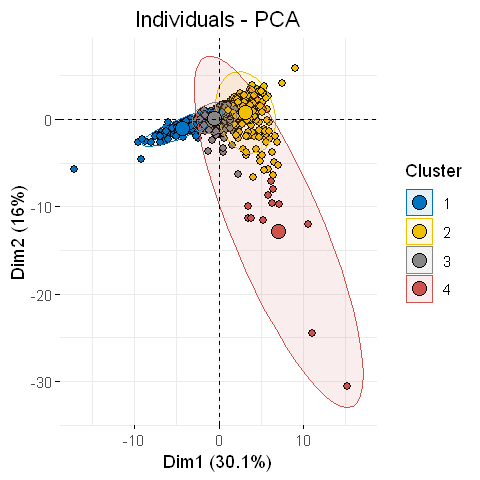

In [175]:
# k = 4

selected_column_indices <- c(4:8,10:31)
num_clusters <- 4 #try some number

jail_county_demographics_filtered_df_dropna <- drop_na(jail_county_demographics_filtered_df)

#opt_k <- fviz_nbclust(jail_county_demographics_filtered_df_dropna[ , selected_column_indices], kmeans, method = "gap_stat")

set.seed(42)
km <- kmeans(scale(jail_county_demographics_filtered_df_dropna[ , selected_column_indices]), num_clusters )
jail_county_demographics_filtered_df_dropna$cluster <- as.factor(km$cluster)
#write.csv(jail_county_demographics_filtered_df_dropna, 'jail_county_demographics_clustered_4means.csv', row.names=FALSE)


# get a sense of the clusters
options(repr.plot.width=4)
ggplot(jail_county_demographics_filtered_df_dropna, 
       aes( x = highrisk_agegroup_perc, y = population_density, color = cluster) ) + 
            geom_point()

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_jail_pop = mean(jail_population),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster, urbanicity ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

#pca
data <- jail_county_demographics_filtered_df_dropna
#pca <- prcomp(data[ , selected_column_indices], center = TRUE, scale = TRUE)
#summary(pca)

# principal components + clusters
plot <- fviz_pca_ind(pca, geom.ind = "point", pointshape = 21, 
             pointsize = 2, 
             fill.ind = data$cluster, 
             col.ind = "black", 
             palette = "jco", 
             addEllipses = TRUE,
             label = "var",
             col.var = "black",
             repel = TRUE,
             legend.title = "Cluster") +
  theme(plot.title = element_text(hjust = 0.5))
plot
#ggsave('4clusterpca.png', plot)

cluster,count,ave_incarceration_rate,ave_jail_pop,ave_res_pop,ave_highrisk_agegroup_perc
1,120,184.5675,86.18333,46187.58,0.2603560
2,184,197.1266,659.78804,486663.04,0.1309805
3,493,252.4696,134.15822,75804.13,0.1843947
4,129,290.5512,271.24031,162970.09,0.1700520
5,45,253.2022,92.95556,43223.38,0.1386927


cluster,urbanicity,count,ave_incarceration_rate,ave_res_pop,ave_highrisk_agegroup_perc
1,rural,95,174.1716,30553.86,0.2552742
1,small/mid,22,228.7727,115593.41,0.2848198
1,suburban,3,189.6000,32279.33,0.2418810
2,rural,49,279.5510,31113.78,0.1346878
2,small/mid,65,201.3646,268930.57,0.1317168
2,suburban,47,144.4170,380720.91,0.1270597
2,urban,23,117.2609,2289002.39,0.1290134
3,rural,268,291.0119,33560.56,0.1888251
3,small/mid,154,204.3818,122185.14,0.1821204
3,suburban,70,212.2943,119209.30,0.1723691


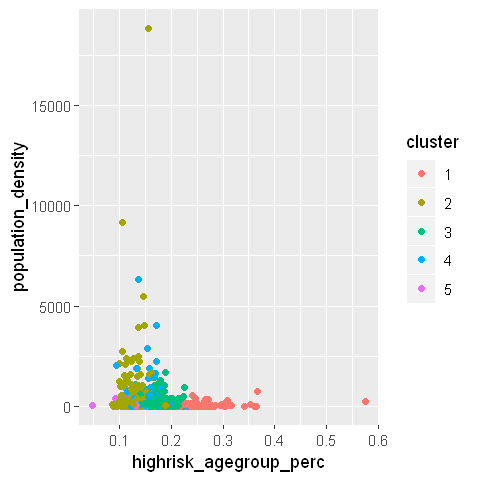

Saving 6.67 x 6.67 in image


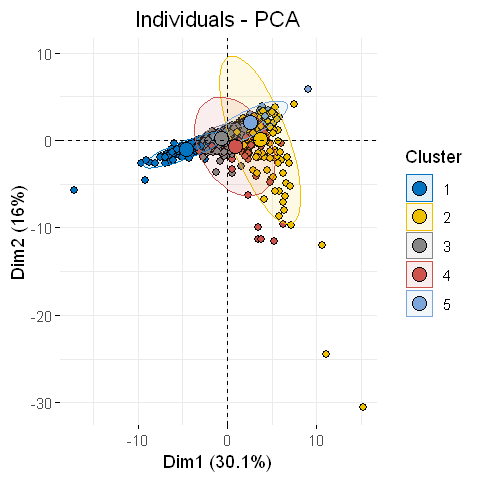

In [176]:
# k = 5

selected_column_indices <- c(4:8,10:31)
num_clusters <- 5 

jail_county_demographics_filtered_df_dropna <- drop_na(jail_county_demographics_filtered_df)

set.seed(42)
km <- kmeans(scale(jail_county_demographics_filtered_df_dropna[ , selected_column_indices]), num_clusters )
jail_county_demographics_filtered_df_dropna$cluster <- as.factor(km$cluster)
#write.csv(jail_county_demographics_filtered_df_dropna, 'jail_county_demographics_clustered_4means.csv', row.names=FALSE)


# get a sense of the clusters
options(repr.plot.width=4)
ggplot(jail_county_demographics_filtered_df_dropna, 
       aes( x = highrisk_agegroup_perc, y = population_density, color = cluster) ) + 
            geom_point()

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_jail_pop = mean(jail_population),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

jail_county_demographics_filtered_df_dropna %>%
    group_by( cluster, urbanicity ) %>%
    summarize( count = n(),
             ave_incarceration_rate = mean(jail_incarceration_rate_per_100k),
             ave_res_pop = mean(resident_population),
             ave_highrisk_agegroup_perc = mean(highrisk_agegroup_perc))

#pca
data <- jail_county_demographics_filtered_df_dropna
#pca <- prcomp(data[ , selected_column_indices], center = TRUE, scale = TRUE)

# principal components + clusters
plot <- fviz_pca_ind(pca, geom.ind = "point", pointshape = 21, 
             pointsize = 2, 
             fill.ind = data$cluster, 
             col.ind = "black", 
             palette = "jco", 
             addEllipses = TRUE,
             label = "var",
             col.var = "black",
             repel = TRUE,
             legend.title = "Cluster") +
  theme(plot.title = element_text(hjust = 0.5))
plot
#ggsave('5clusterpca.png', plot)

In [172]:
# find optimal number of clusters
opt_k <- fviz_nbclust(jail_county_demographics_filtered_df_dropna[ , selected_column_indices], kmeans, method = "gap_stat")

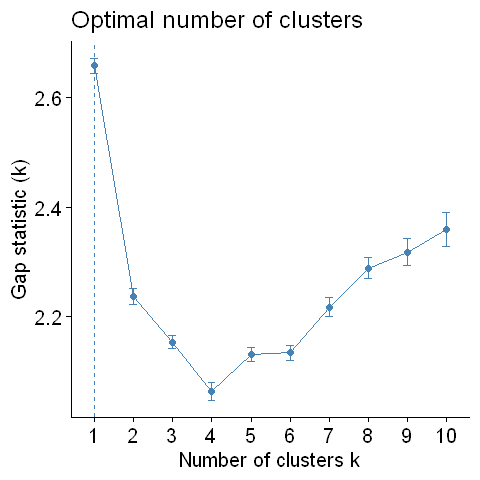

In [14]:
opt_k

# essentially, no obvious clustering

In [123]:
# ---------------
# from jessica's rmd file

prison_pop_df <- read.csv("prison_county_df.csv")[ , 2:34]
prison_counties <- prison_pop_df %>% filter(prison_county==1)
#prison_counties

length(unique(prison_pop_df$countystate))
length(unique(prison_counties$countystate))
nrow(prison_counties)

model1 <- glm(diff_cases ~ tot_pop + frac_released + population_density, data = prison_counties)
#summary(model1)

model2 <- glm(diff_cases ~ tot_pop + prison_county + population_density, data = prison_pop_df)
#summary(model2)

prison_pop_df_with_indicator <-prison_pop_df %>% mutate(frac_released_for_indicator = ifelse(is.na(frac_released),0,frac_released)) %>%
  select(countystate,date,prison_county,frac_released_for_indicator,diff_cases,tot_pop,population_density) %>% drop_na() %>%
  mutate(int_prison_county_frac_released = prison_county*frac_released_for_indicator)

model3 <- glm(diff_cases ~ tot_pop + int_prison_county_frac_released + prison_county + population_density ,data = prison_pop_df_with_indicator)
#summary(model3)

#with(summary(model1), 1 - deviance/null.deviance)
#with(summary(model2), 1 - deviance/null.deviance)
#with(summary(model3), 1 - deviance/null.deviance)

[1] 2885

[1] 858

[1] 37978

In [124]:
prison_pop_df_with_indicator <-prison_pop_df %>% mutate(frac_released_for_indicator = ifelse(is.na(frac_released),0,frac_released)) %>%
  mutate(int_prison_county_frac_released = prison_county*frac_released_for_indicator,
         prison_inc_rate = prison_pop / tot_pop ) ## added prison incarceration rate

model4 <- glm(diff_cases ~ tot_pop + int_prison_county_frac_released + prison_county + population_density + highrisk_agegroup_perc,data = prison_pop_df_with_indicator)
model5 <- glm(diff_cases ~ tot_pop + frac_released + population_density + prison_fullness, data = prison_counties)
model6 <- glm(diff_cases ~ tot_pop + frac_released + population_density + prison_fullness + highrisk_agegroup_perc, data = prison_counties)
model7 <- glm(diff_cases ~ tot_pop + frac_released + population_density + highrisk_agegroup_perc, data = prison_counties)

summary(model7)
summary(model6)
summary(model5)
summary(model4)

extractAIC(model7)
extractAIC(model6) ## smallest AIC
extractAIC(model5) #  second smallest AIC
extractAIC(model4)
extractAIC(model3)
extractAIC(model2)
extractAIC(model1)

with(summary(model7), 1 - deviance/null.deviance)
with(summary(model6), 1 - deviance/null.deviance)
with(summary(model5), 1 - deviance/null.deviance)
with(summary(model4), 1 - deviance/null.deviance)


Call:
glm(formula = diff_cases ~ tot_pop + frac_released + population_density + 
    highrisk_agegroup_perc, data = prison_counties)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2915.7    -45.7    -14.7      5.1   8458.0  

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -5.358e+01  8.784e+00  -6.099 1.08e-09 ***
tot_pop                 2.521e-04  3.320e-06  75.939  < 2e-16 ***
frac_released          -3.681e+02  8.241e+01  -4.467 7.95e-06 ***
population_density      1.587e-01  1.797e-03  88.305  < 2e-16 ***
highrisk_agegroup_perc  2.775e+02  4.648e+01   5.971 2.38e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 133422)

    Null deviance: 7866241663  on 37771  degrees of freedom
Residual deviance: 5038950461  on 37767  degrees of freedom
  (206 observations deleted due to missingness)
AIC: 552957

Number of Fisher Scoring iter


Call:
glm(formula = diff_cases ~ tot_pop + frac_released + population_density + 
    prison_fullness + highrisk_agegroup_perc, data = prison_counties)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2154.6    -37.4    -11.4      4.6   6075.6  

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -2.054e+01  9.407e+00  -2.183  0.02903 *  
tot_pop                 2.771e-04  5.592e-06  49.548  < 2e-16 ***
frac_released          -7.192e+01  7.200e+01  -0.999  0.31785    
population_density      1.373e-01  1.571e-03  87.353  < 2e-16 ***
prison_fullness        -1.761e+01  5.621e+00  -3.132  0.00174 ** 
highrisk_agegroup_perc  1.639e+02  4.130e+01   3.969 7.24e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 82065.58)

    Null deviance: 3772510669  on 28586  degrees of freedom
Residual deviance: 2345516341  on 28581  degrees of freedom
  (9


Call:
glm(formula = diff_cases ~ tot_pop + frac_released + population_density + 
    prison_fullness, data = prison_counties)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2151.4    -37.6    -10.2      4.0   6079.5  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.049e+01  5.233e+00   2.005  0.04502 *  
tot_pop             2.721e-04  5.451e-06  49.918  < 2e-16 ***
frac_released      -5.026e+01  7.181e+01  -0.700  0.48401    
population_density  1.365e-01  1.561e-03  87.465  < 2e-16 ***
prison_fullness    -1.832e+01  5.620e+00  -3.261  0.00111 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 82107.94)

    Null deviance: 3772510669  on 28586  degrees of freedom
Residual deviance: 2346809039  on 28582  degrees of freedom
  (9391 observations deleted due to missingness)
AIC: 404618

Number of Fisher Scoring iterations: 2



Call:
glm(formula = diff_cases ~ tot_pop + int_prison_county_frac_released + 
    prison_county + population_density + highrisk_agegroup_perc, 
    data = prison_pop_df_with_indicator)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3465.7    -21.9     -2.9      6.2   9623.0  

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -3.429e+01  4.083e+00  -8.399  < 2e-16 ***
tot_pop                          3.187e-04  2.274e-06 140.116  < 2e-16 ***
int_prison_county_frac_released -3.780e+02  6.592e+01  -5.734 9.82e-09 ***
prison_county                    1.532e+01  2.019e+00   7.589 3.26e-14 ***
population_density               1.042e-01  1.073e-03  97.088  < 2e-16 ***
highrisk_agegroup_perc           1.204e+02  2.039e+01   5.904 3.56e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 85558.47)

    Null deviance: 1.3925e+

[1]      5 552957

[1]      6.0 404604.1

[1]      5.0 404617.9

[1]       6 1587913

[1]       5 1587946

[1]       4 1587975

[1]      4.0 552990.6

[1] 0.3594208

[1] 0.3782612

[1] 0.3779185

[1] 0.3127104

In [135]:
# add prison incarceration rate
# explore models with prison incarceration rate

prison_counties <- prison_counties %>%
    mutate( prison_inc_rate = prison_pop / tot_pop )

prison_pop_df <- prison_pop_df %>%
    mutate( prison_inc_rate = prison_pop / tot_pop )

model8 <- glm(diff_cases ~ 
              tot_pop + frac_released + population_density + prison_fullness + highrisk_agegroup_perc + prison_inc_rate, 
              data = prison_counties)
model9 <- glm(diff_cases ~ 
              tot_pop  + population_density + prison_fullness + highrisk_agegroup_perc + prison_inc_rate, 
              data = prison_counties)
model10 <- glm(diff_cases ~ 
              tot_pop + frac_released + population_density + prison_fullness + highrisk_agegroup_perc + prison_pop, 
              data = prison_counties)
model11 <- glm(diff_cases ~ 
               tot_pop + frac_released + 
               int_prison_county_frac_released + 
               prison_county + 
               population_density + 
               highrisk_agegroup_perc + 
               prison_inc_rate,
               data = prison_pop_df_with_indicator)
model12 <- glm(diff_cases ~ 
               tot_pop + int_prison_county_frac_released + prison_county + population_density + highrisk_agegroup_perc + prison_pop,
               data = prison_pop_df_with_indicator)

extractAIC(model8)
extractAIC(model9)
extractAIC(model10)
extractAIC(model11)
extractAIC(model12)

summary(model8)

[1]      7.0 404597.1

[1]      6.0 404595.5

[1]      7 404499

[1]      6.0 496677.4

[1]      6.0 496657.4


Call:
glm(formula = diff_cases ~ tot_pop + frac_released + population_density + 
    prison_fullness + highrisk_agegroup_perc + prison_inc_rate, 
    data = prison_counties)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2155.1    -35.3    -12.2      2.1   6075.1  

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -2.374e+01  9.466e+00  -2.508 0.012160 *  
tot_pop                 2.809e-04  5.734e-06  48.985  < 2e-16 ***
frac_released          -4.195e+01  7.268e+01  -0.577 0.563804    
population_density      1.375e-01  1.573e-03  87.411  < 2e-16 ***
prison_fullness        -2.028e+01  5.691e+00  -3.564 0.000366 ***
highrisk_agegroup_perc  1.709e+02  4.136e+01   4.132  3.6e-05 ***
prison_inc_rate         1.149e+02  3.833e+01   2.997 0.002731 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 82042.67)

    Null deviance: 3772510669  on 2